# plot the B-factors from a Servalcat refinement of the model against the density map as well as computed B-factors from the trajectory

In [1]:
# pre-processing for Servalcat: need to invert the hand of the halfmaps
import numpy as np
import mrcfile

halfmap_1 = "../data/6xm5_steered_Roodmus_2/Servalcat/J521_004_volume_map_half_A.mrc"
halfmap_2 = "../data/6xm5_steered_Roodmus_2/Servalcat/J521_004_volume_map_half_B.mrc"

halfmap_1_mrc = mrcfile.open(halfmap_1)
halfmap_2_mrc = mrcfile.open(halfmap_2)

halfmap_1_data = halfmap_1_mrc.data
halfmap_2_data = halfmap_2_mrc.data

# invert the hand of the halfmaps
halfmap_1_data = np.flip(halfmap_1_data, axis=0)
halfmap_2_data = np.flip(halfmap_2_data, axis=0)

# save the inverted halfmaps
with mrcfile.new(halfmap_1.replace(".mrc", "_inverted.mrc"), overwrite=True) as mrc:
    mrc.set_data(halfmap_1_data)

with mrcfile.new(halfmap_2.replace(".mrc", "_inverted.mrc"), overwrite=True) as mrc:
    mrc.set_data(halfmap_2_data)
    

In [8]:
# load the trajectory and compute the B-factors using MDAnalysis
from MDAnalysis.analysis import align
from MDAnalysis.analysis import rms
import numpy as np

trajectory_file = "../data/6xm5_steered_Roodmus_1/trj/trajectory_gpu3_subset.dcd"
topology_file = "../data/6xm5_steered_Roodmus_1/trj/afterMinimisation.pdb"

# align the trajectory to the first frame
traj = mda.Universe(topology_file, trajectory_file)
average = align.AverageStructure(
    traj,
    traj,
    select="protein and not name H*",
    ref_frame=0,
    verbose=True,
).run()
ref = average.results.universe

# compute the rmsf from the trajectory, excluding the hydrogen atoms
aligner = align.AlignTraj(
    traj,
    ref,
    select="protein and not name H*",
    in_memory=True,
).run()
all_atoms = traj.select_atoms("protein and not name H*")
c_alphas = traj.select_atoms("protein and name CA")
rmsf = rms.RMSF(c_alphas).run()
Bcalc = (8 * np.pi**2 * rmsf.results.rmsf**2) / 3

/home/mjoosten1/local/miniconda3/envs/ensemble_refinement/lib/python3.11/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"
100%|██████████| 10000/10000 [00:39<00:00, 256.02it/s]


In [10]:
# read the B-factors from the refined model
import gemmi
refined_model = "../data/6xm5_steered_Roodmus_2/Servalcat/refined.pdb"
refined_model_gemmi = gemmi.read_structure(refined_model)

Bfac = []
atmid = []
resid = []
chnid = []
for chain in refined_model_gemmi[0]:
    for residue in chain:
        for atom in residue:
            if atom.name == "CA":
                Bfac.append(atom.b_iso)
                atmid.append(atom.name)
                resid.append(residue.seqid.num - 1)
                chnid.append(chain.name)


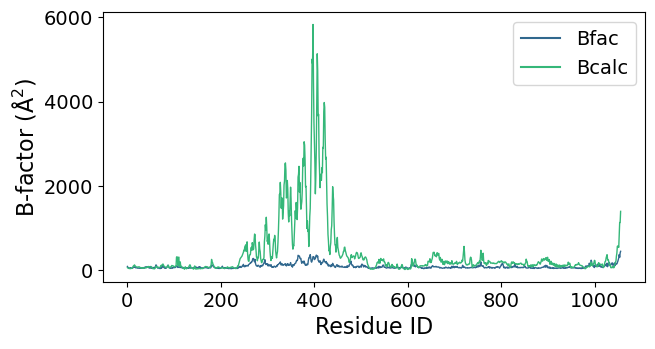

In [19]:
# create a dataframe with the B-factors and plot them
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.DataFrame(
    {
        "chnid": chnid,
        "resid": resid,
        "atmid": atmid,
        "Bfac": Bfac,
        "Bcalc": Bcalc,
    }
)
df = df.melt(id_vars=["chnid", "resid", "atmid"], var_name="Bfactor", value_name="Bvalue")

fig, ax = plt.subplots(figsize=(7, 3.5))
sns.lineplot(
    data=df,
    x="resid",
    y="Bvalue",
    hue="Bfactor",
    palette="viridis",
    linewidth=1,
    ax=ax,
)
# increase tick label size
ax.tick_params(axis="both", which="major", labelsize=14)
ax.set_xlabel("Residue ID", fontsize=16)
ax.set_ylabel("B-factor ($\mathrm{\AA}^2$)", fontsize=16)
ax.legend(fontsize=14)

# save the figure
plt.savefig("figures/J521_004_Bfactors.pdf", bbox_inches="tight")